<a href="https://colab.research.google.com/github/cagBRT/Data/blob/main/5b_Outliers_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/are-outliers-harder-to-predict-ae84dd4be465

In this notebook we work with outliers.  <br>
We try to answer the question, what should we do with outliers?.

## Do ML models make more mistakes with outliers?

Outliers are usually viewed with suspicion and are often removed. <br>

But Is this the best practice?


Outliers are individuals that are very different from the majority of the population. Traditionally, among practitioners there is a certain mistrust in outliers, this is why ad-hoc measures such as removing them from the dataset are often adopted.

Sometimes, outliers are even more important than other observations. <br>

For example, the case of individuals that are outliers because they are very high-paying customers: you don’t want to discard them, if fact, you probably want to treat them with extra care.



In this notebook we try to answer the question: <br>

**Is an ML model more likely to make mistakes when making predictions on outliers?**

To sum up, we may imagine three possibilities:

outliers are harder to predict<br>
outliers are easier to predict<br>
outliers are neither harder nor easier to predict<br>


In [124]:
!pip install pycaret --quiet

In [125]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from scipy.stats import percentileofscore
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import IsolationForest
from category_encoders import CatBoostEncoder
from lightgbm import LGBMClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [126]:
DATASET_NAMES = [ "bank", "blood", "cancer", "credit", "diabetes", "electrical_grid",
                 "employee", "heart", "heart_disease", "hepatitis", "income", "juice",
                 "nba", "wine", "telescope", "titanic", "us_presidential_election_results"]

**Define functions for use in this notebook**

In [127]:
def get_dataset(dataset_name):
  """Get dataset."""
  target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
  df = get_data(dataset_name, verbose=False)
  X, y = df.drop(target_name, axis=1), df[target_name]
  y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])}).iloc[:,0]
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  return X, y, num_features, cat_features

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False

def individual_log_loss(y_true, y_pred, eps=1e-15):
  """Compute log-loss for each individual of the sample."""
  y_pred = np.clip(y_pred, eps, 1 - eps)
  return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

## Case 1

Let's look at a case where a model has been trained on the dataset shown below.

**Plot the synthetic data**

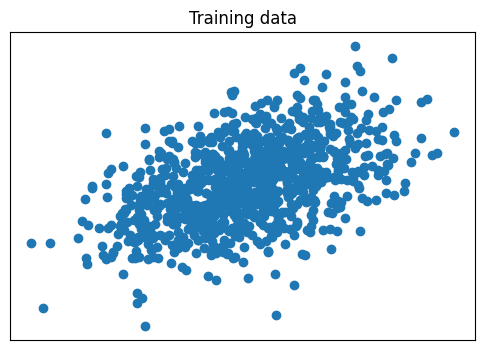

In [128]:
fig, ax = plt.subplots(figsize=(6,4))
x = np.random.multivariate_normal([0,0], [[1,.6],[.6,2]], size=1000)
ax.scatter(x[:,0], x[:,1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Training data")
fig.savefig(f"example_training.png", dpi=200, bbox_inches="tight")

**If new data is collected it can be**:
1. an outlier
2. falls within the standard range for data

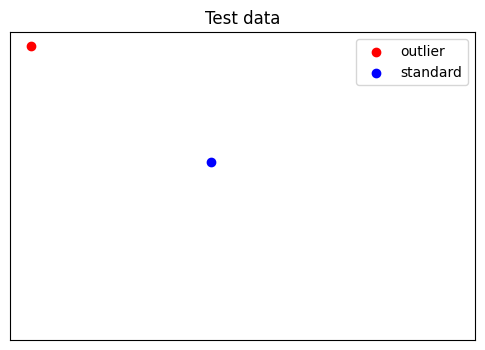

In [129]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x[:,0], x[:,1], color="white")
ax.scatter(np.min(x, axis=0)[0], np.max(x, axis=0)[1], color="red", label="outlier")
ax.scatter(np.quantile(x, q=.3, axis=0)[0], np.quantile(x, q=.7, axis=0)[1], color="blue", label="standard")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Test data")
ax.legend(loc="upper right")
fig.savefig(f"example_test.png", dpi=200, bbox_inches="tight")

**Question for discussion:** <br>
Is the outlier going to harder to predict than the standard data point?<br>



Three possible outcomes: <br>
1. outliers are harder to predict
2. outiers are easier to predict
3. outliers are neither harder or easier to predict

## Experiment 1

We use a bank customer datset. <br>

"bank": https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification




**Get the bank dataset**<br>
The dataset contains:<br>

Personal information: <br>
- age, job, education level, and marital status<br>

account information: <br>
- balance, credit status,housing loan status, personal loan status<br>

marketing information: <br>
- contact method, day of week of last contact, month of last contact, length of last contact, number of contacts, number of contacts, outcome of last campaign<br>

Label: <br>
- the label will predict if the customer will purchase a bank term deposit (Yes=1, No=0)<br>

In [130]:
datasets = get_data(verbose=False)

"bank": https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification<br>

"telescope": https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope

**Prepare the dataset and split into training and test sets**

In [131]:
dataset_name = "bank"
X, y, num_features, cat_features = get_dataset(dataset_name)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Training set:",X_train.shape, y_train.shape)
print("Test set:",X_test.shape, y_test.shape)

Training set: (33908, 16) (33908,)
Test set: (11303, 16) (11303,)


**All the inputs to the model**

In [132]:
print("All features: ",X_train.columns)
print("Numerical features: ",num_features)

All features:  Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
Numerical features:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']




---



---



---



## Categorical Encoding with CatBoost Encoder<br>

We must convert the categorical data to numeric data. There are a number of categircial encoding methods we can use. <br>

In this case we care going to use Catboost. <br>

CatBooset encoding is used for categorical features.
There are various categorical encoding methods available. Catboost is one of them.<br>

Catboost is a target-based categorical encoder. It is a supervised encoder that encodes categorical columns according to the target value. It supports binomial and continuous targets.<br>
[Catboost is a target-based categorical encoder](https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/).  It encodes according to a target value and supports binomial and continuous targets. <br>

Target encoding replaces the categorical values with the average value for each column. This can introduce data leakage since the target is used to predict the target. <br>

Catboost solves the data leakage issue by using an ordering principle.



**A quick example of CatBootEncoder**

In [133]:
# Make dataset
train = pd.DataFrame({
    'color': ["red", "blue", "blue", "green", "red",
              "red", "black", "black", "blue", "green"],

    'interests': ["sketching", "painting", "instruments",
                  "sketching", "painting", "video games",
                  "painting", "instruments", "sketching",
                  "sketching"],

    'height': [68, 64, 87, 45, 54, 64, 67, 98, 90, 87],

    'grade': [1, 2, 3, 2, 3, 1, 4, 4, 2, 3], })

# Define train and target
target = train[['grade']]
train = train.drop('grade', axis = 1)

# Define catboost encoder
cbe_encoder = CatBoostEncoder()

# Fit encoder and transform the features
cbe_encoder.fit(train, target)
train_cbe = cbe_encoder.transform(train)

# We can use fit_transform() instead of fit()
# and transform() separately as follows:
# train_cbe = cbe_encoder.fit_transform(train,target)
train_cbe

,color,interests,height
0,1.875,2.100000,68
1,2.375,2.875000,64
2,2.375,3.166667,87
3,2.500,2.100000,45
4,1.875,2.875000,54
5,1.875,2.500000,64
6,3.500,2.875000,67
7,3.500,3.166667,98
8,2.375,2.100000,90
9,2.500,2.100000,87




---

**End of CatBoostEncoder Example**

---



## Use CatBoostEncoder on our dataset

In [134]:
cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
cat_encoder

CatBoostEncoder(cols=['job', 'marital', 'education', 'default', 'housing',
                      'loan', 'contact', 'month', 'poutcome'])

**The data before CatBoost**

In [135]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
17718,59,management,married,tertiary,no,1069,no,no,cellular,29,jul,85,2,-1,0,unknown
13662,47,services,married,secondary,no,0,yes,no,cellular,9,jul,173,1,-1,0,unknown
41547,56,admin.,single,secondary,no,2815,yes,no,cellular,11,sep,212,1,-1,0,unknown
11035,59,entrepreneur,divorced,unknown,no,0,no,no,unknown,17,jun,956,2,-1,0,unknown
35788,44,blue-collar,married,secondary,no,1343,yes,yes,cellular,8,may,414,2,287,2,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,50,blue-collar,married,secondary,no,160,yes,no,unknown,13,may,334,1,-1,0,unknown
11685,50,management,married,tertiary,no,67,no,yes,unknown,20,jun,156,3,-1,0,unknown
18274,59,retired,married,unknown,no,201,no,no,cellular,31,jul,69,7,-1,0,unknown
32021,44,services,married,secondary,no,1450,yes,no,cellular,14,apr,356,1,314,2,failure


In [136]:
X_train.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

In [137]:
if len(cat_features) > 0:
  #fill empty values with NULL
    cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
  #transform the categorical data to numerical data
    X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
    X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
  #fill any missing data with the mean of the dataset
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())

In [138]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
17718,59,0.134225,0.101930,0.148423,0.118613,1069,0.166996,0.127737,0.149370,29,0.090511,85,2,-1,0,0.092165
13662,47,0.090217,0.101930,0.106168,0.118613,0,0.078266,0.127737,0.149370,9,0.090511,173,1,-1,0,0.092165
41547,56,0.124838,0.149683,0.106168,0.118613,2815,0.078266,0.127737,0.149370,11,0.454813,212,1,-1,0,0.092165
11035,59,0.081334,0.120963,0.139815,0.118613,0,0.166996,0.127737,0.041156,17,0.104034,956,2,-1,0,0.092165
35788,44,0.073797,0.101930,0.106168,0.118613,1343,0.078266,0.064857,0.149370,8,0.067041,414,2,287,2,0.126811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,50,0.073797,0.101930,0.106168,0.118613,160,0.078266,0.127737,0.041156,13,0.067041,334,1,-1,0,0.092165
11685,50,0.134225,0.101930,0.148423,0.118613,67,0.166996,0.064857,0.041156,20,0.104034,156,3,-1,0,0.092165
18274,59,0.234298,0.101930,0.139815,0.118613,201,0.166996,0.127737,0.149370,31,0.090511,69,7,-1,0,0.092165
32021,44,0.090217,0.101930,0.106168,0.118613,1450,0.078266,0.127737,0.149370,14,0.198344,356,1,314,2,0.126811


In [139]:
#X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
#X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
#X_train = X_train.fillna(X_train.mean())
#X_test = X_test.fillna(X_train.mean())

In [140]:
print("training dataset shape:",X_train.shape)
print("test dataset shape:",X_test.shape)

training dataset shape: (33908, 16)
test dataset shape: (11303, 16)


## Isolation Foreset

An Isolation Forest is an unsupervised model which can output a score of outlierness for each individual of your dataset.

It returns the anomaly score of each sample using the IsolationForest algorithm



**Identify outliers in the dataset**

In [141]:
#The number of base estimators in the ensemble = 100
iforest = IsolationForest(n_estimators = 100).fit(X_train)
iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)
print("Anomoly scores for the labels in the test set:\n",iforest_scores_test)

Anomoly scores for the labels in the test set:
 27959    0.408979
35807    0.386089
39602    0.420361
5277     0.499098
19092    0.390867
           ...   
6318     0.464781
2141     0.466298
43025    0.477938
32245    0.500525
17350    0.393256
Length: 11303, dtype: float64


In [142]:
#iforest = IsolationForest(n_estimators = 100).fit(X_train)
#iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)

## LGB Classifier (Light Gradient Boosting Model)

LGB uses decision tree algorithms for ranking, classification, and other machine-learning tasks

In [143]:
model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10002
           1       0.65      0.49      0.56      1301

    accuracy                           0.91     11303
   macro avg       0.79      0.73      0.75     11303
weighted avg       0.90      0.91      0.90     11303



## Log_loss

Log-loss is one of the major metrics to assess the performance of a classification problem.<br>

>"Log-loss is indicative of how close the prediction probability is to the corresponding actual/true value (0 or 1 in case of binary classification). The more the predicted probability diverges from the actual value, the higher is the log-loss value."



**What is log-loss?**<br>

A binary classification algorithm first predicts probability of a record to be classified under class 1 and then classifies the data point (record) under one of the two classes (1 or 0) based on whether the probability crossed a threshold value, which is usually set at 0.5 by default.<br>

![picture](https://github.com/cagBRT/Data/blob/main/images/logLoss.png?raw=1)<br>

Before predicting the class of the record, the model has to predict the probability of the record to be classified under class 1. Remember that it is this prediction probability of a data record that the log-loss value is dependent on.

In [144]:
logloss_test = individual_log_loss(y_test, pred_test)
print(logloss_test)
#Each label with the probability of the record being classified as class 1

27959    0.041304
35807    0.004900
39602    0.022110
5277     0.002572
19092    0.023845
           ...   
6318     0.000546
2141     0.001727
43025    0.863058
32245    0.019592
17350    0.001514
Length: 11303, dtype: float64


**Find the highest anomaly score**
1. Take the anomoly scores and sort them in asending order
2. id will equal the highest anomoly score

In [145]:
id = iforest_scores_test.sort_values().tail(1).index[0]
print("the highest iforest score belongs to customer: ",id)

the highest iforest score belongs to customer:  42462


In [146]:
x = X_train.apply(lambda col: percentileofscore(col, X_test.loc[id, col.name])
).sort_values(key=lambda x: np.abs(50-x), ascending=False).rename("quantile") / 100

In [147]:
pd.concat([iforest_scores_test.rename("outlierness_test"), logloss_test.rename("logloss_test")], axis=1).head()

,outlierness_test,logloss_test
27959,0.408979,0.041304
35807,0.386089,0.004900
39602,0.420361,0.022110
5277,0.499098,0.002572
19092,0.390867,0.023845


In [148]:
print("Column name   score")
print(x)

Column name   score
age          0.996815
previous     0.990799
month        0.987437
poutcome     0.983146
balance      0.974224
job          0.953226
pdays        0.936269
duration     0.859827
housing      0.778297
day          0.274552
marital      0.301212
contact      0.676020
education    0.407455
loan         0.580512
campaign     0.527427
default      0.508833
Name: quantile, dtype: float64


**List the outliers**

In [152]:
out = pd.concat([
    X.loc[id, x.index].rename("original data"), x ], axis=1).round(2)
out

,original data,quantile
age,79,1.00
previous,9,0.99
month,dec,0.99
poutcome,success,0.98
balance,8304,0.97
job,retired,0.95
pdays,275,0.94
duration,456,0.86
housing,no,0.78
day,9,0.27


In [151]:
outliers=out[(out["quantile"] > .95) | (out["quantile"] < .05)]
outliers

,original data,quantile
age,79,1.00
previous,9,0.99
month,dec,0.99
poutcome,success,0.98
balance,8304,0.97


In [108]:
#The max iforest_scores_test
print("this is the max outlierness scoure: ",iforest_scores_test.max())

this is the max outlierness scoure:  0.6862068820341791


In [119]:
final=pd.concat([iforest_scores_test.rename("outlierness_test"),
           logloss_test.rename("logloss_test")], axis=1)
final

,outlierness_test,logloss_test
20315,0.394696,0.003976
13727,0.447764,0.003949
11294,0.449258,0.004308
3560,0.474105,0.000620
22053,0.469804,0.007738
...,...,...
19876,0.476748,0.010989
25502,0.457459,0.035720
41110,0.390125,0.010647
12364,0.496944,0.006360


**Get the most extreme outlier**

In [153]:
#Get information about the customer with the highest outlierness
final.loc[final["outlierness_test"].idxmax()]


outlierness_test    0.686207
logloss_test        1.233045
Name: 43342, dtype: float64

In [154]:
print(X.loc[[43342]])

       age         job marital education default  balance housing loan  \
43342   27  management  single  tertiary      no     6791      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome  
43342  telephone   22   mar       174         2    229        28  success  


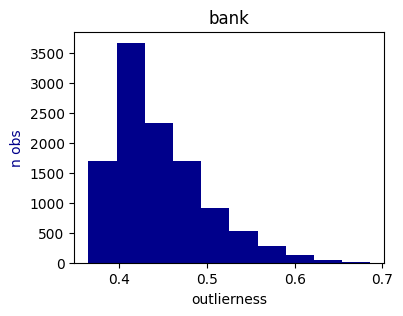

In [107]:
fig, ax1 = plt.subplots(figsize=(4,3))
ax1.hist(iforest_scores_test, color="darkblue")
ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")
fig.savefig(f"{dataset_name}_hist.png", dpi=200, bbox_inches="tight")

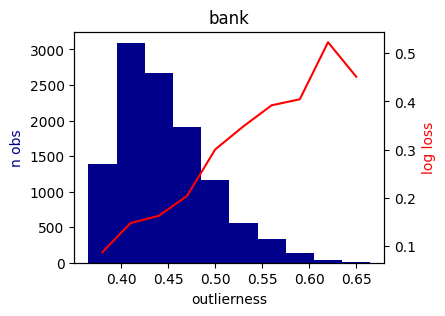

In [155]:
cut=pd.cut(iforest_scores_test, bins=10)
logloss = logloss_test.groupby(cut).mean()
fig, ax1 = plt.subplots(figsize=(4,3))
ax2 = ax1.twinx()
ax1.hist(iforest_scores_test, color="darkblue")
ax2.plot([i.mid for i in logloss.index], logloss, color="red")
ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")
ax2.set_ylabel("log loss", color="red")
fig.savefig(f"{dataset_name}_hist_logloss.png", dpi=200, bbox_inches="tight")

Repeat for different datasets

In [156]:
dataset_names = []
for dataset_name in DATASET_NAMES:
  X, y, num_features, cat_features = get_dataset(dataset_name)
  if len(X) > 5000: dataset_names.append(dataset_name)

In [41]:
results = []
for dataset_name in tqdm(dataset_names):
  X, y, num_features, cat_features = get_dataset(dataset_name)
  for iteration in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    if len(cat_features) > 0:
       cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
       X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
       X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
       X_train = X_train.fillna(X_train.mean())
       X_test = X_test.fillna(X_train.mean())
       iforest = IsolationForest(n_estimators = 100).fit(X_train)
       iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)
       model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
       pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
       logloss_test = individual_log_loss(y_test, pred_test)
       iforest_q95 = iforest_scores_test.quantile(.95)
       outliers_vs_rest = (iforest_scores_test > iforest_q95).replace({True: "outliers", False: "rest"})
       logloss = logloss_test.groupby(outliers_vs_rest).mean()
       results.append({ "dataset name": dataset_name, "iteration": iteration, "n outliers": (iforest_scores_test > iforest_q95).sum(), "log-loss": logloss.mean(), "log-loss (outliers)": logloss["outliers"], "log-loss (rest)": logloss["rest"] })

100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


In [42]:
results_agg = pd.DataFrame(results).groupby("dataset name").agg({ "dataset name": lambda x: x.values[0], "iteration": lambda x: len(x), "n outliers": np.min, "log-loss": np.mean, "log-loss (outliers)": np.mean, "log-loss (rest)": np.mean, })
results_agg["ratio"] = np.maximum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"]) / np.minimum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"])
results_agg = results_agg.sort_values("ratio", ascending=False)

In [43]:
results_agg.loc[:,["log-loss","log-loss (outliers)","log-loss (rest)"]].round(3).style.apply(lambda x: ["background: red" if (v > results_agg["log-loss"].iloc[e] and x.name =="log-loss (outliers)") else ("background: lightgreen"
                                                                                                                                                                                                               if x.name=="log-loss (outliers)" else "") for e, v in enumerate(x)])

,log-loss,log-loss (outliers),log-loss (rest)
dataset name,,,
bank,0.302000,0.418000,0.185000
employee,0.043000,0.029000,0.056000
income,0.247000,0.212000,0.282000
